Twitter Sentiment Analysis SDP Project

In [76]:
# installing kaggle library
%pip install kaggle

In [77]:
# API to fetch the dataset from kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [78]:
# extracting the compressed dataset

from zipfile import ZipFile
dataset = 'sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing the dependencies

In [79]:
# utilities
import numpy as np
import pandas as pd
import re
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [80]:
# tensorflow
%pip install keras_preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

Data Processing

In [81]:
# loading the data from csv file to pandas dataframe
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [82]:
# checking the number of rows and columns
twitter_data.shape


(1599999, 6)

In [83]:
# printing the 1st 5 rows of the dataframe
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [84]:
# naming the columns and reading the datset again

column_names = ['target','id','date','flag','user','text']
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv', names=column_names, encoding = 'ISO-8859-1')

In [10]:
# checking the number of rows and columns
twitter_data.shape

(1600000, 6)

In [11]:
# printing the 1st 5 rows of the dataframe
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
# data information
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
# counting the number of missing values in the dataset
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [14]:
print('Count of columns in the dataset : ', len(twitter_data.columns))
print('Count of rows in the dataset : ', len(twitter_data))

Count of columns in the dataset :  6
Count of rows in the dataset :  1600000


In [15]:
# converting the target from "4" to "1"
twitter_data.replace({'target':{4:1}}, inplace=True)

C:\Users\ritvi\AppData\Local\Temp\ipykernel_21108\4254246701.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=twitter_data, palette=['#ff0000', '#00ff00'])


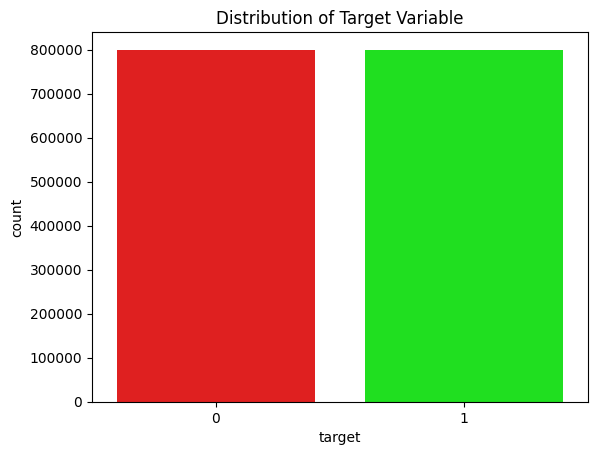

In [16]:
# plotting the distribution of dataset
import seaborn as sns
sns.countplot(x='target', data=twitter_data, palette=['#ff0000', '#00ff00'])

# Add a title and show the plot
plt.title('Distribution of Target Variable')
plt.show()

In [17]:
# verifying the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

0--> Negative Tweet
1--> Positive Tweet

Selecting the text and Target column for our further analysis

In [18]:
data=twitter_data[['text','target']]

Plotting a wordcloud for negative tweets

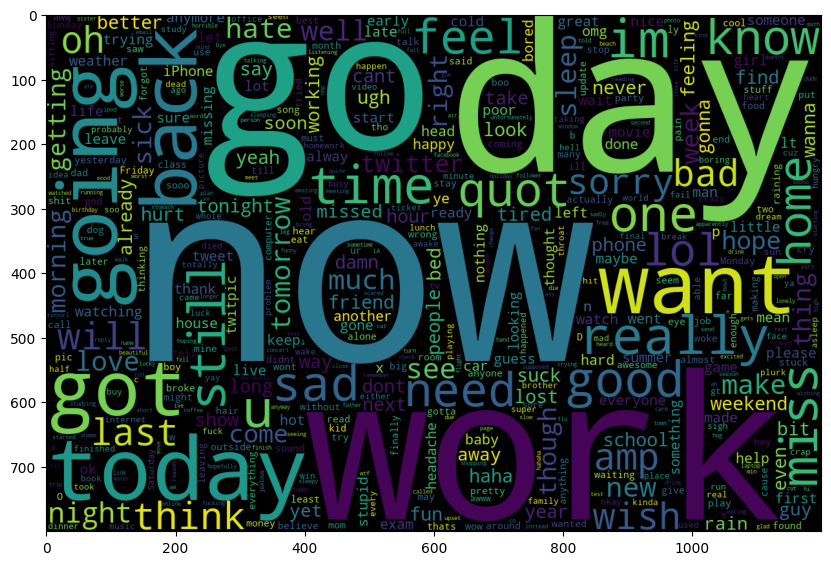

In [19]:
data_neg = data['text'][:800000]
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500 , width = 1200 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Plotting a wordcloud for positive tweets

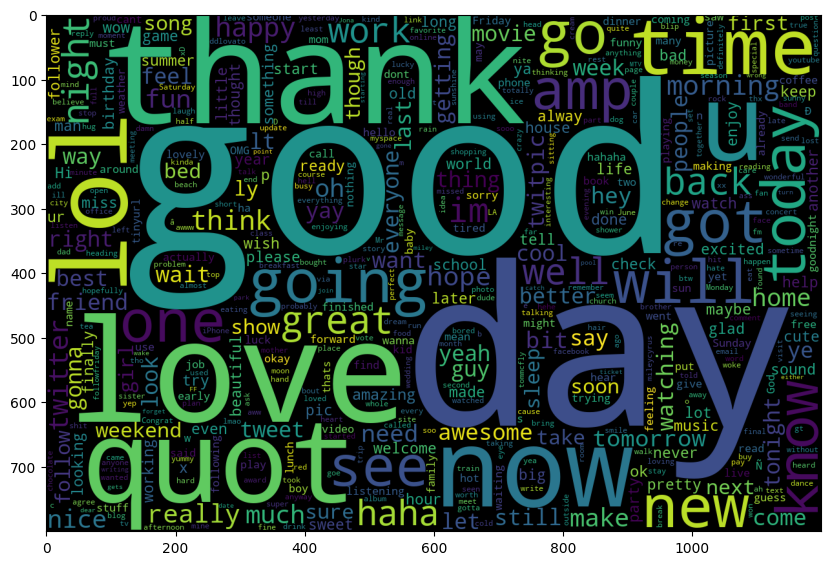

In [20]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 500 , width = 1200 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.imshow(wc)

Separating positve and negative tweets

In [44]:
data_pos = twitter_data[twitter_data['target'] == 1]
data_neg = twitter_data[twitter_data['target'] == 0]

Taking a small amount of the data so we can run it on our machine easily

In [45]:
data_pos = data_pos.iloc[:int(50000)]
data_neg = data_neg.iloc[:int(50000)]

Combining positive and negative tweets

In [46]:
dataset = pd.concat([data_pos, data_neg])

Making tweets text column in lowercase

In [47]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

49995    @mileycyrus so i have the same insomnia prob a...
49996    20 mintues late for my meeting starting @ 8  h...
49997    @kentucky_derby super excited! are you tweetin...
49998    i want another day off!!!!  to much sh#t to do...
49999                 i just jacked up this umbrella cake 
Name: text, dtype: object

Defining set containing all stopwords in English

In [48]:
import nltk
nltk.download('stopwords')
# Extract the stopwords from the WordListCorpusReader object
stopwordlist = nltk.corpus.stopwords.words('english')
# printing the stopwords in english
print(stopwordlist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ritvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning and removing the above stop words list from the tweet text

In [49]:
# Create a set of stopwords
STOPWORDS = set(stopwordlist)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Apply the cleaning function to the text column
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))

# Display the first few rows of the cleaned text column
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

Cleaning and removing punctuations

In [50]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

49995    mileycyrus insomnia prob slept 3 hrs woke 5am ...
49996    20 mintues late meeting starting  8 howd know ...
49997    kentuckyderby super excited tweeting event hap...
49998    want another day off much sht today got quotne...
49999                                 jacked umbrella cake
Name: text, dtype: object

Cleaning and removing repeating characters

In [51]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

49995    mileycyrus insomnia prob slept 3 hrs woke 5am ...
49996    20 mintues late meeting starting  8 howd know ...
49997    kentuckyderby super excited tweeting event hap...
49998    want another day off much sht today got quotne...
49999                                 jacked umbrella cake
Name: text, dtype: object

Cleaning and removing URLs

In [52]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

49995    mileycyrus insomnia prob slept 3 hrs woke 5am ...
49996    20 mintues late meeting starting  8 howd know ...
49997    kentuckyderby super excited tweeting event hap...
49998    want another day off much sht today got quotne...
49999                                 jacked umbrella cake
Name: text, dtype: object

Cleaning and removing numeric numbers

In [53]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

49995    mileycyrus insomnia prob slept  hrs woke am nd...
49996     mintues late meeting starting   howd know goi...
49997    kentuckyderby super excited tweeting event hap...
49998    want another day off much sht today got quotne...
49999                                 jacked umbrella cake
Name: text, dtype: object

In [31]:
# Tokenize the text data only for LSTM MODEL
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])

# please do not use tokenizer while implementing ML models (just for this code)

Applying Stemming

In [54]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

Applying Lemmatization

In [55]:
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

Separating input feature and label

In [56]:
X=dataset.text
Y=dataset.target

In [35]:
# only for LSTM model
# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=100)

Splitting the data into training data and test data

In [36]:
# For LSTM Model (Deep Learning)
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y, test_size=0.2 , random_state=42)

In [57]:
# For NB, SVM, LR and RFC (Machine Learning)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2 , random_state=42)

In [58]:
print(X.shape, X_train.shape, X_test.shape)

(100000,) (80000,) (20000,)


In [59]:
print(X_train)

25220     well despite crappy start day ive actually got...
848955                    nprmorningprod nice twitter story
844966                                archibaldcrane thanks
813568    tallivansunder something ive trying years sooo...
42727     got outta work gf wants go out eh mood head hu...
                                ...                        
806265    mezglinks hiiiiiiiiiiiiii twitter best word li...
4886               hurts u gotta keep goin crawl duvet hide
26820     lindyasimus also negative again nicotine addic...
800860              msdebramaye heard contest congrats girl
815795    johnlloydtaylor greggarbo jacklawless jonasbro...
Name: text, Length: 80000, dtype: object


In [39]:
print(X_test)

[[    0     0     0 ...  1291  1020  4512]
 [    0     0     0 ...    10     7  2390]
 [    0     0     0 ...  3290    42  4818]
 ...
 [    0     0     0 ... 58422  5725    37]
 [    0     0     0 ... 70288   771  1712]
 [    0     0     0 ... 24916    33  5851]]


Skip to Feature Extraction if performing ML algorithms

Build the LSTM Model

In [40]:
# for LSTM model
model = keras.Sequential([
    keras.layers.Embedding(len(tokenizer.word_index) + 1, 128, input_length=100),
    keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\ritvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Train the LSTM model

In [41]:
# for LSTM model
model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 353s 140ms/step - accuracy: 0.7012 - loss: 0.5566 - val_accuracy: 0.7706 - val_loss: 0.4773
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 353s 141ms/step - accuracy: 0.8527 - loss: 0.3419 - val_accuracy: 0.7454 - val_loss: 0.5473
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 362s 145ms/step - accuracy: 0.9196 - loss: 0.1989 - val_accuracy: 0.7405 - val_loss: 0.6145
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 372s 149ms/step - accuracy: 0.9512 - loss: 0.1236 - val_accuracy: 0.7342 - val_loss: 0.7418
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 380s 152ms/step - accuracy: 0.9653 - loss: 0.0869 - val_accuracy: 0.7278 - val_loss: 1.0216


Evaluate the LSTM model

In [42]:
# for LSTM model
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Accuracy:', accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7281 - loss: 1.0183
Test Accuracy: 0.7277500033378601


Plotting the ROC-AUC Curve for LSTM model

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step


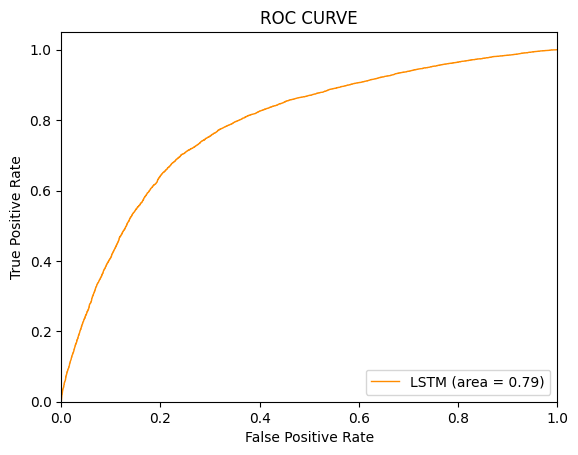

In [43]:
# only for lstm model
from sklearn.metrics import roc_curve, auc
y_pred_LSTM = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_LSTM)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='LSTM (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

After getting the results in LSTM model, we have to go back and start executing from cell 22 i.e. Separating positve and negative tweets

This time ignore the tokenizer cell

Feature Extraction (Machine Learning)

In [60]:
# converting the textual data to numerical data

vector = TfidfVectorizer()

X_train = vector.fit_transform(X_train)
X_test = vector.transform(X_test)

In [61]:
print(X_train)

  (0, 74626)	0.17003561520787533
  (0, 6278)	0.20099040693386422
  (0, 42467)	0.15879930508224283
  (0, 23208)	0.19865859004401654
  (0, 74253)	0.2025179705200212
  (0, 82153)	0.40287235166158547
  (0, 18937)	0.22051327164661383
  (0, 2046)	0.3094794169683949
  (0, 58782)	0.2639250693777433
  (0, 27196)	0.16886917443856564
  (0, 574)	0.23780194240521152
  (0, 36106)	0.2024855274703342
  (0, 16641)	0.1542389108208568
  (0, 69824)	0.2310369538482361
  (0, 14954)	0.31375195711285536
  (0, 17649)	0.33909096285096435
  (0, 80505)	0.17880418974405
  (1, 70450)	0.4770856449305067
  (1, 77161)	0.30804879307594263
  (1, 51202)	0.32925209650273524
  (1, 52349)	0.7543794041689175
  (2, 73260)	0.37750731565032264
  (2, 3684)	0.9260066018287816
  (3, 82939)	0.2418865219884659
  (3, 65466)	0.3010812954354118
  :	:
  (79996, 39481)	0.2767410509958719
  (79996, 27223)	0.28942702005934035
  (79996, 33899)	0.30225448601235694
  (79997, 42668)	0.5229904540005059
  (79997, 51369)	0.5047046187319214
  (799

In [62]:
print(X_test)

  (0, 82063)	0.24349037353364125
  (0, 61987)	0.37536449530679156
  (0, 50685)	0.36445229093989145
  (0, 46205)	0.23182326685463225
  (0, 43113)	0.3910399388946942
  (0, 42929)	0.2989360144023247
  (0, 40057)	0.32741189900981593
  (0, 27196)	0.2077093166505786
  (0, 19024)	0.4697124097560751
  (1, 81849)	0.3265881905153266
  (1, 63624)	0.4141388388496494
  (1, 48945)	0.7081716463057719
  (1, 26778)	0.3253607582978956
  (1, 5187)	0.33832302951555027
  (2, 83276)	0.19608808962862115
  (2, 78051)	0.38739179763255105
  (2, 76553)	0.22519271169151528
  (2, 74073)	0.1838055012835117
  (2, 64601)	0.654638407547785
  (2, 60664)	0.3659877632927915
  (2, 51008)	0.21802425183171337
  (2, 47700)	0.3033725248128411
  (2, 26169)	0.1578381633728079
  (3, 79894)	0.24080714734210285
  (3, 76006)	0.3716804285709639
  :	:
  (19995, 74184)	0.8643970997555955
  (19995, 24247)	0.5028097591874239
  (19996, 82080)	0.369565618485643
  (19996, 60766)	0.279127489911573
  (19996, 53204)	0.6005175280989299
  (1999

Now we will evaluate Accuracy score, Confusion Matrix with Plot, and ROC-AUC curve

In [64]:
def model_Evaluate(model):
# Predict values for Test dataset
  Y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
  print(classification_report(Y_test, Y_pred))
# Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(Y_test, Y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [65]:
del zip

Training the machine learning model:

1. Logistic Regression

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9965
           1       0.76      0.78      0.77     10035

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



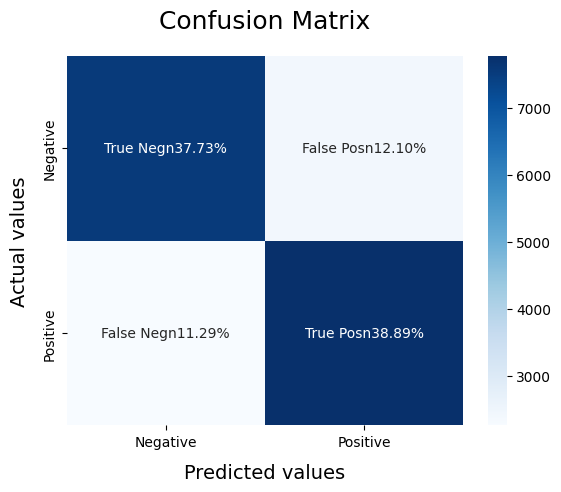

In [66]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, Y_train)
model_Evaluate(LRmodel)
y_pred1 = LRmodel.predict(X_test)

 Support column: It is the sum of true positives and false negatives for each class.



Plotting the ROC-AUC Curve for  LR model

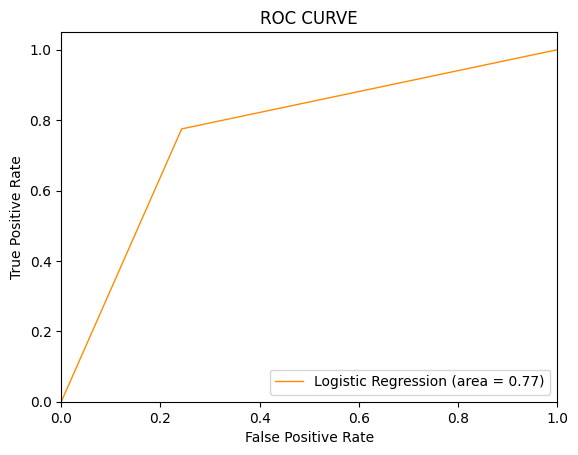

In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

2. Naive Bayes

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      9965
           1       0.78      0.72      0.75     10035

    accuracy                           0.75     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.76      0.75      0.75     20000



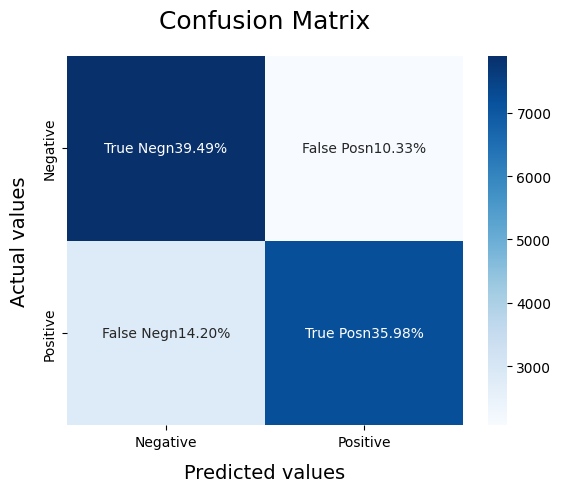

In [68]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, Y_train)
model_Evaluate(BNBmodel)
y_pred2 = BNBmodel.predict(X_test)

Plotting the ROC-AUC Curve for
BNB model

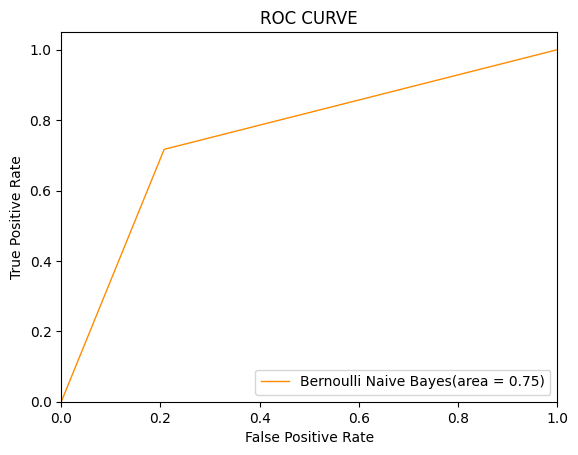

In [69]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Bernoulli Naive Bayes(area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

3. Support Vector Machine (SVM)

c:\Users\ritvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.75      0.75      9965
           1       0.76      0.76      0.76     10035

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



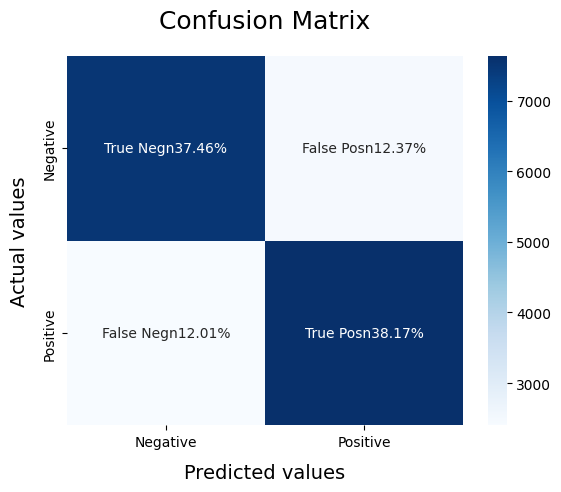

In [70]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, Y_train)
model_Evaluate(SVCmodel)
y_pred3 = SVCmodel.predict(X_test)

Plotting the ROC-AUC Curve for SVC model

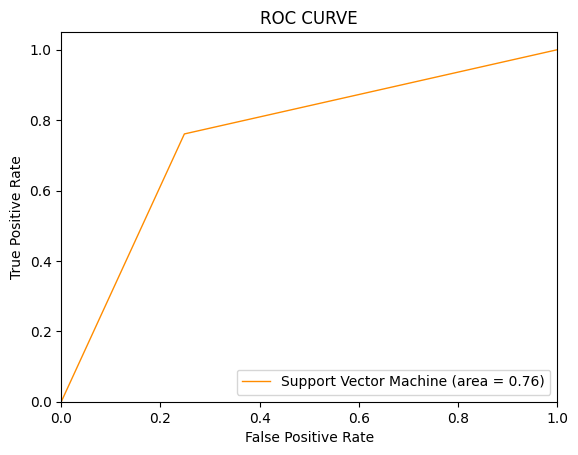

In [71]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Support Vector Machine (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

4. Random Forest Classifier

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      9965
           1       0.77      0.72      0.74     10035

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



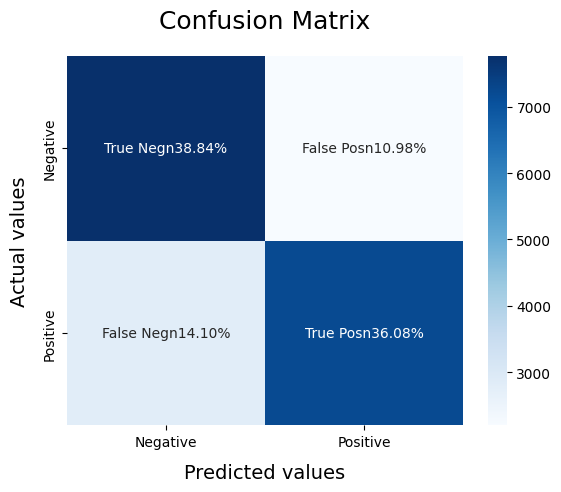

In [66]:
RFCmodel = RandomForestClassifier(n_jobs=-1)

RFCmodel.fit(X_train, Y_train)
model_Evaluate(RFCmodel)
y_pred4 = RFCmodel.predict(X_test)

Plotting the ROC-AUC Curve for RFC model

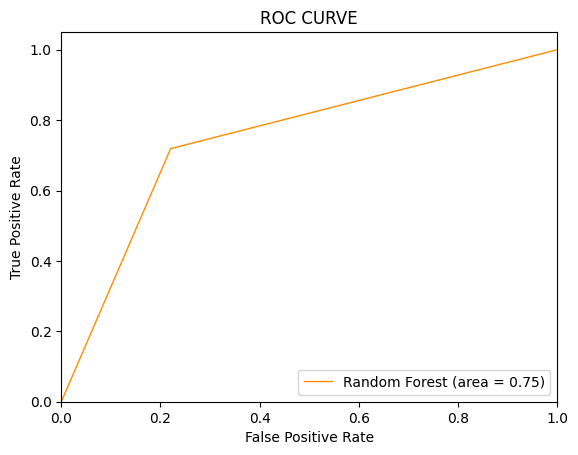

In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='Random Forest (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

5. Combining existing models

In [72]:
# Define the individual classifiers
clf1 = BernoulliNB()
clf2 = LinearSVC()
clf3 = LogisticRegression()

# Create the ensemble classifier
eclf = VotingClassifier(estimators=[('Naive Bayes', clf1),
                                 ('SVM', clf2),
                                 ('Logistic Regression', clf3)],
                                  voting='hard')

# Train the ensemble classifier
eclf.fit(X_train, Y_train)


c:\Users\ritvi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


VotingClassifier(estimators=[('Naive Bayes', BernoulliNB()),
                             ('SVM', LinearSVC()),
                             ('Logistic Regression', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      9965
           1       0.77      0.76      0.77     10035

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



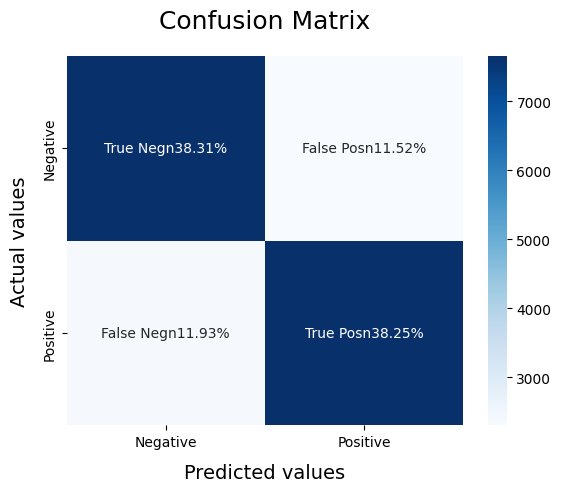

In [73]:
model_Evaluate(eclf)
y_pred5 = eclf.predict(X_test)

Final ROC AUC Curve for all the models

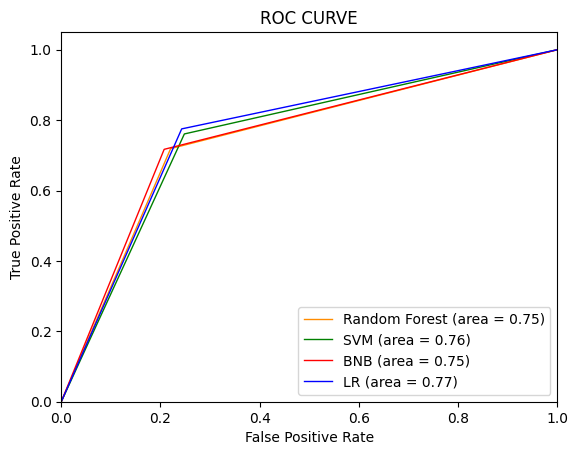

In [70]:
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(Y_test, y_pred4)
fpr2, tpr2, thresholds2 = roc_curve(Y_test, y_pred3)
fpr3, tpr3, thresholds3 = roc_curve(Y_test, y_pred2)
fpr4, tpr4, thresholds4 = roc_curve(Y_test, y_pred1)
#fpr5, tpr5, thresholds5 = roc_curve(Y_test, y_pred_LSTM)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
#roc_auc5 = auc(fpr5, tpr5)
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='Random Forest (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=1, label='SVM (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='red', lw=1, label='BNB (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='blue', lw=1, label='LR (area = %0.2f)' % roc_auc4)
#plt.plot(fpr5, tpr5, color='cyan', lw=1, label='LSTM (area = %0.2f)' % roc_auc5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

Model Evaluation

We can change the model names and check the accuracy here

In [75]:
# accuracy score on the training data
X_train_pred = eclf.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_pred)
print('Accuracy score on the training data: ', training_data_accuracy)

Accuracy score on the training data:  0.896


Model Accuracy Training(LR)= 86.97% (BNB)= 87.60% (SVM)= 94.03% (RFC)= 99.81%
 (VC)= 89.61% (LSTM)=97.05%

In [60]:
# accuracy score on the test data
X_test_pred = eclf.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_pred)
print('Accuracy score on the test data: ', test_data_accuracy)

Accuracy score on the test data:  0.76555


Model Accuracy Testing(LR)= 76.81% (BNB)= 75.46% (SVM)= 75.63% (RFC)= 74.65% (VC)= 76.54% (LSTM)=72.83%

Saving the trained model

In [71]:
import pickle

In [72]:
saved_model = 'saved_LRmodel.sav'
pickle.dump(LRmodel, open(saved_model,'wb'))

In [73]:
vector_model = 'saved_vectorizer.pkl'
pickle.dump(vector, open(vector_model,'wb'))

Using the saved model for future predictions

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('/content/saved_LRmodel.sav', 'rb'))

In [61]:
X_new = X_test[200]
print(Y_test[2])

prediction= LRmodel.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('Negative')
else:
  print('Positive')

0
[1]
Positive
